In [1]:
import scipy as sp
import numpy as np
import BATT as b
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
from scipy.integrate import solve_bvp

%matplotlib inline

In [2]:
# initializing constants
K = 0.06    #liquid conductivity
s = 20.     #solid conductivity
a = 23300.  #area/volume
ac = 0.5    #alpha cathode
aa = 0.5    #alpha anode
io = 2e-7   #exchange current density
L = .5      #length
n = 1       #exchanged electrons
F = 96485   #Faraday's constant
R = 8.314   #gas constant
T = 298     #temperature
I = 0.1     #total current density
L_sep = 0.1 #length of separator
Resist_sep = 1 #resistance of separator per length

In [3]:
Vwall1 = 1
Vwall2 = 1

def BCCath(ya, yb):
    return (yb[0] - I), (ya[1] - I), ya[3] - Vwall_2, yb[1]
#     return (ya[0] - I), yb[0], (yb[1] - I), ya[2]# (yb[4] - I), ya[4], (ya[5] - I), ya[2], (ya[6])

def BCAn(ya, yb):
    return (yb[1] - I), (ya[0] - I), yb[3], yb[0]
#     return (ya[0] - I), yb[0], (yb[1] - I), ya[2]# (yb[4] - I), ya[4], (ya[5] - I), ya[2], (ya[6])
      
def TafelCath(x, IV):
    """
    uses Tafel kinetics
    """
    is_p, ie_p, Vs_p, Ve_p = IV
    #n represents anode attributes, p represents cathode attributes
    
    taff_p = -ac*n*F/(R*T)*(Vs_p - Ve_p)
    die_p = -a*io*np.exp(taff_p)
    #Kinetics
    
    dis_p = -die_p
    #charge neutrality
    
    dVs_p = -is_p/s
    #solids ohms law
    
    dVe_p = -ie_p/K
    #liquids ohms law

    return dis_p, die_p, dVs_p, dVe_p

def TafelAn(x, IV):
    """
    uses Tafel kinetics
    """
    
    is_n, ie_n, Vs_n, Ve_n = IV
    #n represents anode attributes, p represents cathode attributes
    
    taff_n = aa*n*F/(R*T)*(Vs_n - Ve_n)
    die_n = a*io*np.exp(taff_n)
    #Kinetics
    
    dis_n = -die_n
    #charge neutrality
    
    dVs_n = -is_n/s
    #solids ohms law
    
    dVe_n = -ie_n/K
    #liquids ohms law

    return dis_n, die_n, dVs_n, dVe_n

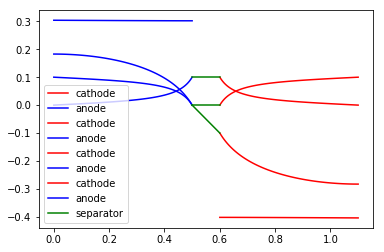

In [4]:
N = 10
N_sep = 20
x_cath = np.linspace(L + L_sep, 2*L + L_sep, N)
x_an = np.linspace(0, L, N)
y = np.zeros([4, N])

x_plot_cath = np.linspace(L + L_sep, L_sep + 2*L, 100)
x_plot_an = np.linspace(0, L, 100)

An = solve_bvp(TafelAn, BCAn, x_an, y)
Vwall_1 = An.sol(x_plot_an)[3][-1]

x_sep = np.linspace(L, L + L_sep, N_sep)
is_sep = np.ones(N_sep) * An.sol(x_plot_an)[0][-1]
ie_sep = np.ones(N_sep) * An.sol(x_plot_an)[1][-1]
Ve_sep = np.zeros(N_sep)
Ve_sep[0] = Vwall_1
for i in range(N_sep):
    Ve_sep[i] = Vwall_1 - (x_sep[i] - L) * Resist_sep

Vwall_2 = Ve_sep[-1]
Cath = solve_bvp(TafelCath, BCCath, x_cath, y)
# Ta_IV = solve_bvp(Tafelfunc_a, BC_a, x, y)
# Tc_IV = solve_bvp(Tafelfunc_c, BC_c, x, y)

for i in range(4):
    plt.plot(x_plot_cath, Cath.sol(x_plot_cath)[i], color = 'r', label = 'cathode')
    plt.plot(x_plot_an, An.sol(x_plot_an)[i], color = 'b', label = 'anode')

plt.plot(x_sep, Ve_sep, color = 'g')
plt.plot(x_sep, is_sep, color = 'g')
plt.plot(x_sep, ie_sep, color = 'g', label = 'separator')

plt.legend(loc = 'best')

In [9]:
def USS_TafelAn(x, IV):
    """
    uses Tafel kinetics
    """
    
    is_n, ie_n, Vs_n, Ve_n = IV
    #n represents anode attributes, p represents cathode attributes
    
    x_data = i_lim_x.copy() #np.linspace(0, L, 10)
    y_data = i_lim.copy()   #np.array([1,1,1,1,1,1,1,1,1,1])
#     print(x_data, y_data)
    f = sp.interpolate.interp1d(x_data, y_data)
    die_n_lim = f(x)
#     print(die_n_lim)
    
    taff_n = aa*n*F/(R*T)*(Vs_n - Ve_n)
    taff_c = -ac*n*F/(R*T)*(Vs_n - Ve_n)
    die_n = (np.exp(taff_n)-np.exp(taff_c))/(1/(a*io)+(np.exp(taff_n)-np.exp(taff_c))/die_n_lim)
    #print(die_n)
    #Kinetics
    
    dis_n = -die_n
    #charge neutrality
    
    dVs_n = -is_n/s
    #solids ohms law
    
    dVe_n = -ie_n/K
    #liquids ohms law

    return dis_n, die_n, dVs_n, dVe_n

In [10]:
coulomb_density = 5.03/86.9368 * F
ro = 0.001
print(coulomb_density) #C/cm^3

5582.440922601246


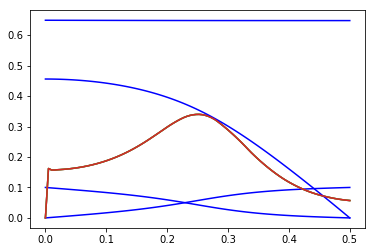

In [60]:
N = 10
N_sep = 20
x_cath = np.linspace(L + L_sep, 2*L + L_sep, N)
x_an = np.linspace(0, L, N)
y = np.zeros([4, N])
i_lim_x = np.linspace(0,L,100)
i_lim = np.ones(i_lim_x.size)

x_plot_cath = np.linspace(L + L_sep, L_sep + 2*L, 100)
x_plot_an = np.linspace(0, L, 100)

# An = solve_bvp(USS_TafelAn, BCAn, x_an, y)

holder = []

for i in range(59):
    #print(i_lim)
    An = solve_bvp(USS_TafelAn, BCAn, x_an, y)
    ie = An.sol(i_lim_x)[1]
    #print(ie)
    z = np.array([0])
    zprime = np.concatenate((z, np.diff(ie)/np.diff(i_lim_x)))
    holder = np.concatenate([holder, zprime], axis = 0)
    i_lim = i_lim - zprime * .05
#     print(i_lim)

for i in range(4):
    plt.plot(x_plot_an, An.sol(x_plot_an)[i], color = 'b', label = 'anode')
    plt.plot(i_lim_x, zprime)


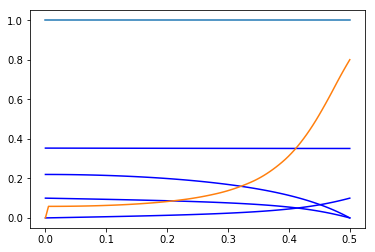

In [61]:
i_lim_x = np.linspace(0,L,100)
i_lim = np.ones(i_lim_x.size)
An = solve_bvp(USS_TafelAn, BCAn, x_an, y)

ie = An.sol(i_lim_x)[1]
zprime = np.concatenate((z, np.diff(ie)/np.diff(i_lim_x)))

for i in range(4):
    plt.plot(x_plot_an, An.sol(x_plot_an)[i], color = 'b', label = 'anode')
plt.plot(i_lim_x, i_lim)
plt.plot(i_lim_x, zprime)

In [62]:
print(holder)

[ 0.          0.05846425  0.05846286 ...,  0.0592178   0.05802761
  0.05702803]


In [71]:
holder = holder.reshape((100,59))

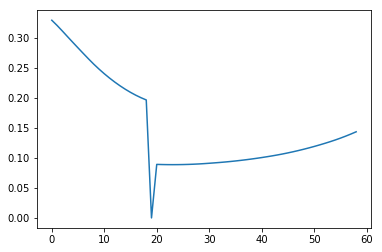

In [77]:
plt.plot(range(59),holder[59,:])